<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week10.do.txt --no_mako -->
<!-- dom:TITLE: Weeks 10 and 11: Recurrent neural networks  -->

# Weeks 10 and 11: Recurrent neural networks 
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and Facility for Rare Isotope Beams, Michigan State University

Date: **March 6-17, 2023**

## Plans for weeks 10 and 11, March 6-17

* Wrapping up Convolutional Neural Networks

* Recurrent neural networks

* [Video of lecture at with subtitles](https://youtu.be/VvgiK3TUdxg)

## Resources on Deeep learning

**Excellent lectures on CNNs and RNNs.**

* [Video  on Convolutional Neural Networks from MIT](https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini)

* [Video  on Recurrent Neural Networks from MIT](https://www.youtube.com/watch?v=SEnXr6v2ifU&ab_channel=AlexanderAmini)

* [Video on Deep Learning](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

**Reading recommendations:**

1. For RNNs see Goodfellow et al chapter 10. See also chapter 11 and 12 on practicalities and applications

2. Reading suggestions for implementation of RNNs: [Aurelien Geron's chapter 14](https://github.com/CompPhysics/MachineLearning/blob/master/doc/Textbooks/TensorflowML.pdf). 

3. [Deep Learning Tutorial on AEs from Stanford University](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)

4. [Building AEs in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

5. [Introduction to AEs in TensorFlow](https://www.tensorflow.org/tutorials/generative/autoencoder)

6. [Grosse, University of Toronto, Lecture on AEs](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/slides/lec20.pdf)

7. [Bank et al on AEs](https://arxiv.org/abs/2003.05991)

## Building convolutional neural networks in Tensorflow and Keras

As discussed earlier, CNNs are neural networks built from the assumption that the inputs
to the network are 2D images. This is important because the number of features or pixels in images
grows very fast with the image size, and an enormous number of weights and biases are needed in order to build an accurate network.  

As before, we still have our input, a hidden layer and an output. What's novel about convolutional networks
are the **convolutional** and **pooling** layers stacked in pairs between the input and the hidden layer.
In addition, the data is no longer represented as a 2D feature matrix, instead each input is a number of 2D
matrices, typically 1 for each color dimension (Red, Green, Blue).

## Setting it up

It means that to represent the entire
dataset of images, we require a 4D matrix or **tensor**. This tensor has the dimensions:

$$
(n_{inputs},\, n_{pixels, width},\, n_{pixels, height},\, depth) .
$$

## The MNIST dataset again

The MNIST dataset consists of grayscale images with a pixel size of
$28\times 28$, meaning we require $28 \times 28 = 724$ weights to each
neuron in the first hidden layer.

If we were to analyze images of size $128\times 128$ we would require
$128 \times 128 = 16384$ weights to each neuron. Even worse if we were
dealing with color images, as most images are, we have an image matrix
of size $128\times 128$ for each color dimension (Red, Green, Blue),
meaning 3 times the number of weights $= 49152$ are required for every
single neuron in the first hidden layer.

## Strong correlations

Images typically have strong local correlations, meaning that a small
part of the image varies little from its neighboring regions. If for
example we have an image of a blue car, we can roughly assume that a
small blue part of the image is surrounded by other blue regions.

Therefore, instead of connecting every single pixel to a neuron in the
first hidden layer, as we have previously done with deep neural
networks, we can instead connect each neuron to a small part of the
image (in all 3 RGB depth dimensions).  The size of each small area is
fixed, and known as a [receptive](https://en.wikipedia.org/wiki/Receptive_field).

## Layers of a CNN
The layers of a convolutional neural network arrange neurons in 3D: width, height and depth.  
The input image is typically a square matrix of depth 3. 

A **convolution** is performed on the image which outputs
a 3D volume of neurons. The weights to the input are arranged in a number of 2D matrices, known as **filters**.

Each filter slides along the input image, taking the dot product
between each small part of the image and the filter, in all depth
dimensions. This is then passed through a non-linear function,
typically the **Rectified Linear (ReLu)** function, which serves as the
activation of the neurons in the first convolutional layer. This is
further passed through a **pooling layer**, which reduces the size of the
convolutional layer, e.g. by taking the maximum or average across some
small regions, and this serves as input to the next convolutional
layer.

## Systematic reduction

By systematically reducing the size of the input volume, through
convolution and pooling, the network should create representations of
small parts of the input, and then from them assemble representations
of larger areas.  The final pooling layer is flattened to serve as
input to a hidden layer, such that each neuron in the final pooling
layer is connected to every single neuron in the hidden layer. This
then serves as input to the output layer, e.g. a softmax output for
classification.

## Prerequisites: Collect and pre-process data

In [1]:
%matplotlib inline

# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

## Importing Keras and Tensorflow

In [2]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
#from tensorflow.keras import Conv2D
#from tensorflow.keras import MaxPooling2D
#from tensorflow.keras import Flatten

from sklearn.model_selection import train_test_split

# representation of labels
labels = to_categorical(labels)

# split into train and test data
# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

## Running with Keras

In [3]:
def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(layers.Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_neurons_connected, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(layers.Dense(n_categories, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

epochs = 100
batch_size = 100
input_shape = X_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 50
n_categories = 10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

## Final part

In [4]:
CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
        CNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = CNN.evaluate(X_test, Y_test)
        
        CNN_keras[i][j] = CNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

## Final visualization

In [5]:
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(X_test, Y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## The CIFAR01 data set

The CIFAR10 dataset contains 60,000 color images in 10 classes, with
6,000 images in each class. The dataset is divided into 50,000
training images and 10,000 testing images. The classes are mutually
exclusive and there is no overlap between them.

In [6]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# We import the data set
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1 by dividing by 255. 
train_images, test_images = train_images / 255.0, test_images / 255.0

## Verifying the data set

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
​
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Set up  the model

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer.

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Let's display the architecture of our model so far.

model.summary()

You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

## Add Dense layers on top

To complete our model, you will feed the last output tensor from the
convolutional base (of shape (4, 4, 64)) into one or more Dense layers
to perform classification. Dense layers take vectors as input (which
are 1D), while the current output is a 3D tensor. First, you will
flatten (or unroll) the 3D output to 1D, then add one or more Dense
layers on top. CIFAR has 10 output classes, so you use a final Dense
layer with 10 outputs and a softmax activation.

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
Here's the complete architecture of our model.

model.summary()

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

## Compile and train the model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
​
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

## Finally, evaluate the model

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

## Recurrent neural networks (RNNs): Overarching view

Till now our focus has been, including convolutional neural networks
as well, on feedforward neural networks. The output or the activations
flow only in one direction, from the input layer to the output layer.

A recurrent neural network (RNN) looks very much like a feedforward
neural network, except that it also has connections pointing
backward. 

RNNs are used to analyze time series data such as stock prices, and
tell you when to buy or sell. In autonomous driving systems, they can
anticipate car trajectories and help avoid accidents. More generally,
they can work on sequences of arbitrary lengths, rather than on
fixed-sized inputs like all the nets we have discussed so far. For
example, they can take sentences, documents, or audio samples as
input, making them extremely useful for natural language processing
systems such as automatic translation and speech-to-text.

## More examples

When applying machine learning to sequences, we often want to turn an input sequence into an output sequence that lives in a different domain.
* As example, consider turning a sequence of sound pressures into a sequence of word identities.

a. When there is no separate target sequence, we can get a teaching signal by trying to predict the next term in the input sequence.

b. The target output sequence is the input sequence with an advance of 1 step.

c. This seems much more natural than trying to predict one pixel in an image from the other pixels, or one patch of an image from the rest of the image.

d. For temporal sequences there is a natural order for the predictions.

## A simple example

In [12]:
# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 



# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

plt.plot(df)
plt.show()

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

### Memoryless models

Autoregressive models Predict the next term in a sequence from a fixed number of
previous terms using **delay taps**.

**Feed-forward neural networks.**

These generalize autoregressive
models by using one or more
layers of non-linear hidden units.

If we give our generative model some hidden state, and if we give
this hidden state its own internal dynamics, we get a much more
interesting kind of model.
1. It can store information in its hidden state for a long time.

2. If the dynamics is noisy and the way it generates outputs from its hidden state is noisy, we can never know its exact hidden state.

3. The best we can do is to infer a probability distribution over the

space of hidden state vectors.

This inference is only tractable for two types of hidden state model.

### Linear dynamical model

If we give our generative model some hidden state, and if we give
this hidden state its own internal dynamics, we get a much more
interesting kind of model.
1. It can store information in its hidden state for a long time.

a. If the dynamics is noisy and the way it generates outputs from its hidden state is noisy, we can never know its exact hidden state.

2. The best we can do is to infer a probability distribution over the space of hidden state vectors.

### Hidden Markov Models

Hidden Markov Models have a discrete oneof-$N$ hidden state. Transitions between states
are stochastic and controlled by a transition
matrix. The outputs produced by a state are
stochastic.
* We cannot be sure which state produced a given output. So the state is “hidden”.

* It is easy to represent a probability distribution across N states with N numbers.

* To predict the next output we need to infer the probability distribution over hidden states.

HMMs have efficient algorithms for inference and learning

### RNNs

RNNs are very powerful, because they
combine two properties:
1. Distributed hidden state that allows them to store a lot of information about the past efficiently.

2. Non-linear dynamics that allows them to update their hidden state in complicated ways.

With enough neurons and time, RNNs
can compute anything that can be
computed by your computer.

### Do generative models need to be stochastic?

**Linear dynamical systems and hidden Markov models are stochastic models.**

But the posterior probability
distribution over their
hidden states given the
observed data so far is a
deterministic function of the
data.

**Recurrent neural networks are deterministic.**

Think of the hidden state
of an RNN as the
equivalent of the
deterministic probability
distribution over hidden
states in a linear dynamical
system or hidden Markov
model.

### What kinds of behaviour can RNNs exhibit?

1. They can oscillate. Good for motor control?

2. They can settle to point attractors. Good for retrieving memories?

3. They can behave chaotically. Bad for information processing?

4. RNNs could potentially learn to implement lots of small programs that each capture a nugget of knowledge and run in parallel, interacting to produce very complicated effects.

But the computational power of RNNs makes them very hard to train.

### Backpropagation through time

We can think of the recurrent net as a layered, feed-forward
net with shared weights and then train the feed-forward net
with weight constraints.

We can also think of this training algorithm in the time domain:
1. The forward pass builds up a stack of the activities of all the units at each time step.

2. The backward pass peels activities off the stack to compute the error derivatives at each time step.

3. After the backward pass we add together the derivatives at all the different times for each weight. 

<!-- dom:FIGURE: [figslides/RNN1.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN1.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN2.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN2.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN3.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN3.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN4.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN4.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN5.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN5.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

### We need to specify the initial activity state of all the hidden and output units

1. We could just fix these initial states to have some default value like 0.5.

2. But it is better to treat the initial states as learned parameters.

3. We learn them in the same way as we learn the weights.

* Start off with an initial random guess for the initial states.

a. At the end of each training sequence, backpropagate through time all the way to the initial states to get the gradient of the error function with respect to each initial state.

b. Adjust the initial states by following the negative gradient.

### We can specify inputs in several ways

1. Specify the initial states of all the units.

2. Specify the initial states of a subset of the units.

3. Specify the states of the same subset of the units at every time step.

This is the natural way to model most sequential data.

### We can specify targets in several ways

1. Specify desired final activities of all the units

2. Specify desired activities of all units for the last few steps

* Good for learning attractors

* It is easy to add in extra error derivatives as we backpropagate.

  * Specify the desired activity of a subset of the units.

* The other units are input or hidden units.

### The backward pass is linear

* There is a big difference between the forward and backward passes.

* In the forward pass we use squashing functions (like the logistic) to prevent the activity vectors from exploding.

* The backward pass, is completely linear. If you double the error derivatives at the final layer, all the error derivatives will double.

The forward pass determines the slope of the linear function used for
backpropagating through each neuron

<!-- dom:FIGURE: [figslides/RNN6.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN6.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN7.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN7.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN8.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN8.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN9.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN9.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN10.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN10.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN11.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN11.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN12.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN12.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

### The problem of exploding or vanishing gradients

* What happens to the magnitude of the gradients as we backpropagate through many layers?

a. If the weights are small, the gradients shrink exponentially.

b. If the weights are big the gradients grow exponentially.

* Typical feed-forward neural nets can cope with these exponential effects because they only have a few hidden layers.

* In an RNN trained on long sequences (e.g. 100 time steps) the gradients can easily explode or vanish.

a. We can avoid this by initializing the weights very carefully.

* Even with good initial weights, its very hard to detect that the current target output depends on an input from many time-steps ago.

RNNs have difficulty dealing with long-range dependencies.

### Four effective ways to learn an RNN

1. Long Short Term Memory Make the RNN out of little modules that are designed to remember values for a long time.

2. Hessian Free Optimization: Deal with the vanishing gradients problem by using a fancy optimizer that can detect directions with a tiny gradient but even smaller curvature.

3. Echo State Networks: Initialize the input a hidden and hidden-hidden and output-hidden connections very carefully so that the hidden state has a huge reservoir of weakly coupled oscillators which can be selectively driven by the input.

  * ESNs only need to learn the hidden-output connections.

4. Good initialization with momentum Initialize like in Echo State Networks, but then learn all of the connections using momentum

## Summary of RNNs
Recurrent neural networks (RNNs) have in general no probabilistic component
in a model. With a given fixed input and target from data, the RNNs learn the intermediate
association between various layers.
The inputs, outputs, and internal representation (hidden states) are all
real-valued vectors.

In a  traditional NN, it is assumed that every input is
independent of each other.  But with sequential data, the input at a given stage $t$ depends on the input from the previous stage $t-1$

## A typical RNN

1. Weight matrices $U$, $W$ and $V$ that connect the input layer at a stage $t$ with the hidden layer $h_t$, the previous hidden layer $h_{t-1}$ with $h_t$ and the hidden layer $h_t$ connecting with the output layer at the same stage and producing an output $\tilde{y}_t$, respectively.

2. The output from the hidden layer $h_t$ is oftem modulated by a $\tanh{}$ function $h_t=f(x_t,h_{t-1})=\tanh{(Ux_t+Wh_{t-1}+b)}$ with $b$ a bias value

3. The output from the hidden layer produces $\tilde{y}_t=g(Vh_t+c)$ where $c$ is a new bias parameter.

4. The output from the training at a given stage is in turn compared with the observation $y_t$ thorugh a chosen cost function.

The function $g$ can any of the standard activation functions, that is a Sigmoid, a Softmax, a ReLU and other.
The parameters are trained through the so-called back-propagation through time (BPTT) algorithm.

### Gating mechanism: Long Short Term Memory (LSTM)

LSTM uses a memory cell for 
modeling long-range dependencies and avoid vanishing gradient
 problems.
Capable of modeling longer term dependencies by having
memory cells and gates that controls the information flow along
with the memory cells.

1. Introduced by Hochreiter and Schmidhuber (1997) who solved the problem of getting an RNN to remember things for a long time (like hundreds of time steps).

2. They designed a memory cell using logistic and linear units with multiplicative interactions.

3. Information gets into the cell whenever its “write” gate is on.

4. The information stays in the cell so long as its **keep** gate is on.

5. Information can be read from the cell by turning on its **read** gate.

### Implementing a memory cell in a neural network

To preserve information for a long time in
the activities of an RNN, we use a circuit
that implements an analog memory cell.

1. A linear unit that has a self-link with a weight of 1 will maintain its state.

2. Information is stored in the cell by activating its write gate.

3. Information is retrieved by activating the read gate.

4. We can backpropagate through this circuit because logistics are have nice derivatives. 

<!-- dom:FIGURE: [figslides/RNN13.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN13.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN14.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN14.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN15.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN15.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN16.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN16.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN17.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN17.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN18.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN18.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN19.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN19.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN20.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN20.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN21.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN21.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN22.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN22.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## An extrapolation example

The following code provides an example of how recurrent neural
networks can be used to extrapolate to unknown values of physics data
sets.  Specifically, the data sets used in this program come from
a quantum mechanical many-body calculation of energies as functions of the number of particles.

In [5]:

# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import tensorflow.keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
# For timing the code
from timeit import default_timer as timer
# For plotting
import matplotlib.pyplot as plt


# The data set
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

## Formatting the Data

The way the recurrent neural networks are trained in this program
differs from how machine learning algorithms are usually trained.
Typically a machine learning algorithm is trained by learning the
relationship between the x data and the y data.  In this program, the
recurrent neural network will be trained to recognize the relationship
in a sequence of y values.  This is type of data formatting is
typically used time series forcasting, but it can also be used in any
extrapolation (time series forecasting is just a specific type of
extrapolation along the time axis).  This method of data formatting
does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the
form of (x,y) so the machine learning algorithm learns to assiciate a
y value with a given x value.  This is useful when the test data has x
values within the same range as the training data.  However, for this
application, the x values of the test data are outside of the x values
of the training data and the traditional method of training a machine
learning algorithm does not work as well.  For this reason, the
recurrent neural network is trained on sequences of y values of the
form ((y1, y2), y3), so that the network is concerned with learning
the pattern of the y data and not the relation between the x and y
data.  As long as the pattern of y data outside of the training region
stays relatively stable compared to what was inside the training
region, this method of training can produce accurate extrapolations to
y values far removed from the training data set.

<!--  -->
<!-- The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html). -->
<!--  -->
<!-- The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow. -->
<!--  -->
<!-- Note: Using a sequence length of two is not required for time series forecasting so any lenght of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points. -->

In [6]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output


# ## Defining the Recurrent Neural Network Using Keras
# 
# The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

## Predicting New Points With A Trained Recurrent Neural Network

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 200)               40400     
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 1s 520ms/step - loss: 0.2826 - val_loss: 0.4733
Epoch 2/150
1/1 [==============================] - 0s 30ms/step - loss: 0.1536 - val_loss: 0.1910
Epoch 3/150
1/1 [==============================] - 0s 44ms/step - loss: 0.0649 - val_loss: 0.0382
Epoch 4/150
1/1 [=======

1/1 [==============================] - 0s 37ms/step - loss: 3.7638e-05 - val_loss: 1.5903e-04
Epoch 74/150
1/1 [==============================] - 0s 35ms/step - loss: 5.5632e-05 - val_loss: 2.0575e-04
Epoch 75/150
1/1 [==============================] - 0s 39ms/step - loss: 6.7946e-05 - val_loss: 2.1528e-04
Epoch 76/150
1/1 [==============================] - 0s 37ms/step - loss: 6.9886e-05 - val_loss: 1.8747e-04
Epoch 77/150
1/1 [==============================] - 0s 29ms/step - loss: 6.1486e-05 - val_loss: 1.3514e-04
Epoch 78/150
1/1 [==============================] - 0s 33ms/step - loss: 4.6708e-05 - val_loss: 7.7183e-05
Epoch 79/150
1/1 [==============================] - 0s 31ms/step - loss: 3.1291e-05 - val_loss: 3.0703e-05
Epoch 80/150
1/1 [==============================] - 0s 31ms/step - loss: 2.0282e-05 - val_loss: 5.1512e-06
Epoch 81/150
1/1 [==============================] - 0s 34ms/step - loss: 1.6250e-05 - val_loss: 4.6285e-07
Epoch 82/150
1/1 [==============================] 

1/1 [==============================] - 0s 34ms/step - loss: 1.3688e-05 - val_loss: 2.1026e-05
Epoch 150/150
1/1 [==============================] - 0s 35ms/step - loss: 1.3677e-05 - val_loss: 2.0082e-05


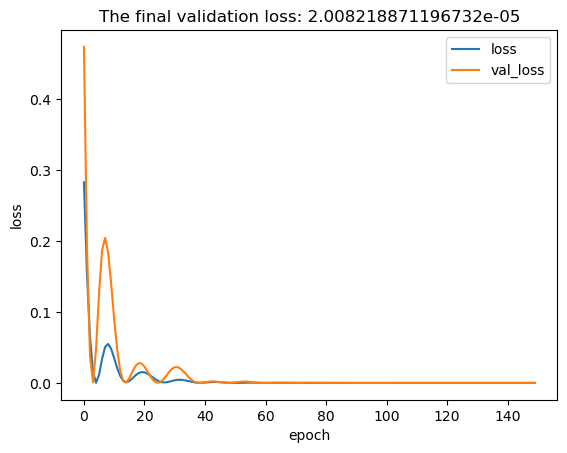

MSE:  9.979015048759959e-05


/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_96311/3370771014.py:33: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  next_input = np.array([[last, next[0]]], dtype=np.float64)


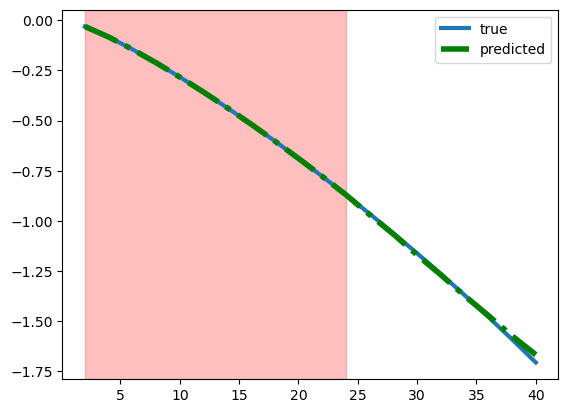

Time:  6.677907000000232


In [7]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn(length_of_sequences = rnn_input.shape[1])
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Things to Try

Changing the size of the recurrent neural network and its parameters
can drastically change the results you get from the model.  The below
code takes the simple recurrent neural network from above and adds a
second hidden layer, changes the number of neurons in the hidden
layer, and explicitly declares the activation function of the hidden
layers to be a sigmoid function.  The loss function and optimizer can
also be changed but are kept the same as the above network.  These
parameters can be tuned to provide the optimal result from the
network.  For some ideas on how to improve the performance of a
[recurrent neural network](https://danijar.com/tips-for-training-recurrent-neural-networks).

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN1 (SimpleRNN)            (None, 2, 500)            251000    
                                                                 
 RNN2 (SimpleRNN)            (None, 500)               500500    
                                                                 
 dense (Dense)               (None, 1)                 501       
                                                                 
Total params: 752,001
Trainable params: 752,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 1s 834ms/step - loss: 0.0836 - val_loss: 8.2943
Epoch 2/150
1/1 [==============================] - 0s 223ms/step - loss: 10.9273 - val

1/1 [==============================] - 0s 45ms/step - loss: 0.0431 - val_loss: 0.1571
Epoch 75/150
1/1 [==============================] - 0s 41ms/step - loss: 0.0419 - val_loss: 0.1740
Epoch 76/150
1/1 [==============================] - 0s 54ms/step - loss: 0.0414 - val_loss: 0.1906
Epoch 77/150
1/1 [==============================] - 0s 48ms/step - loss: 0.0416 - val_loss: 0.2033
Epoch 78/150
1/1 [==============================] - 0s 48ms/step - loss: 0.0423 - val_loss: 0.2096
Epoch 79/150
1/1 [==============================] - 0s 46ms/step - loss: 0.0428 - val_loss: 0.2087
Epoch 80/150
1/1 [==============================] - 0s 45ms/step - loss: 0.0427 - val_loss: 0.2013
Epoch 81/150
1/1 [==============================] - 0s 46ms/step - loss: 0.0422 - val_loss: 0.1897
Epoch 82/150
1/1 [==============================] - 0s 50ms/step - loss: 0.0416 - val_loss: 0.1769
Epoch 83/150
1/1 [==============================] - 0s 43ms/step - loss: 0.0413 - val_loss: 0.1655
Epoch 84/150
1/1 [=====

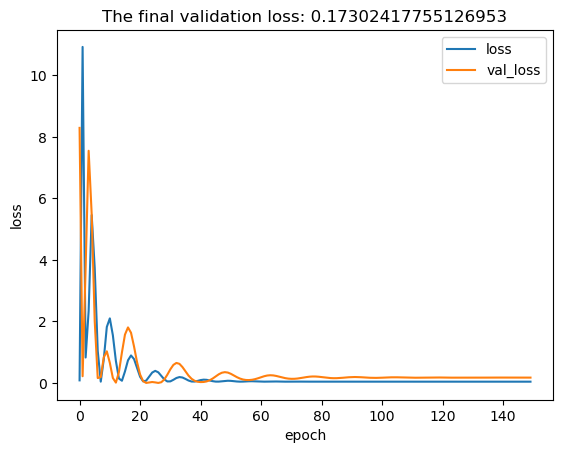

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_96311/3370771014.py:33: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  next_input = np.array([[last, next[0]]], dtype=np.float64)


MSE:  0.33029350134844143


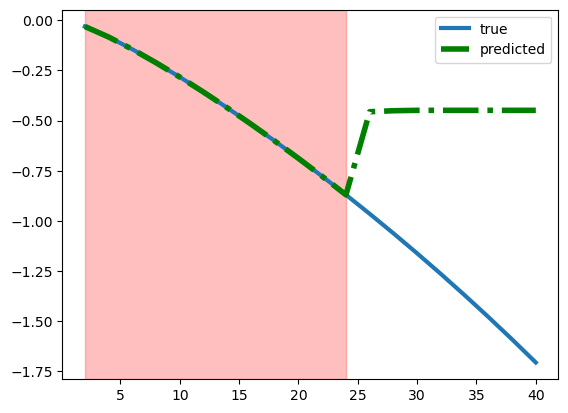

Time:  9.33787858300002


In [8]:
def rnn_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two hidden layers and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer, increased from the first network
    hidden_neurons = 500
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Create two hidden layers instead of one hidden layer.  Explicitly set the activation
    # function to be the sigmoid function (the default value is hyperbolic tangent)
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,  # This needs to be True if another hidden layer is to follow
                    stateful = stateful, activation = 'sigmoid',
                    name="RNN1")(inp)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=False, activation = 'sigmoid',
                    stateful = stateful,
                    name="RNN2")(rnn1)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn2)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn_2layers(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Types of Recurrent Neural Networks

Besides a simple recurrent neural network layer, there are two other
commonly used types of recurrent neural network layers: Long Short
Term Memory (LSTM) and Gated Recurrent Unit (GRU).  For a short
introduction to these layers see <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>
and <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>.

The first network created below is similar to the previous network,
but it replaces the SimpleRNN layers with LSTM layers.  The second
network below has two hidden layers made up of GRUs, which are
preceeded by two dense (feeddorward) neural network layers.  These
dense layers "preprocess" the data before it reaches the recurrent
layers.  This architecture has been shown to improve the performance
of recurrent neural networks (see the link above and also
<https://arxiv.org/pdf/1807.02857.pdf>.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 dnn (Dense)                 (None, 2, 125)            250       
                                                                 
 dnn1 (Dense)                (None, 2, 125)            15750     
                                                                 
 RNN1 (GRU)                  (None, 2, 250)            282750    
                                                                 
 RNN (GRU)                   (None, 250)               376500    
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                                 
Total params: 675,501
Trainable params: 675,501
Non-trainab

1/1 [==============================] - 0s 34ms/step - loss: 3.9343e-05 - val_loss: 2.2266e-04
Epoch 70/150
1/1 [==============================] - 0s 33ms/step - loss: 2.4720e-05 - val_loss: 4.8972e-04
Epoch 71/150
1/1 [==============================] - 0s 37ms/step - loss: 4.8426e-05 - val_loss: 7.2782e-04
Epoch 72/150
1/1 [==============================] - 0s 38ms/step - loss: 8.3547e-05 - val_loss: 8.2258e-04
Epoch 73/150
1/1 [==============================] - 0s 41ms/step - loss: 9.8962e-05 - val_loss: 7.3850e-04
Epoch 74/150
1/1 [==============================] - 0s 35ms/step - loss: 8.3885e-05 - val_loss: 5.3336e-04
Epoch 75/150
1/1 [==============================] - 0s 38ms/step - loss: 5.2947e-05 - val_loss: 3.0848e-04
Epoch 76/150
1/1 [==============================] - 0s 37ms/step - loss: 3.0500e-05 - val_loss: 1.4165e-04
Epoch 77/150
1/1 [==============================] - 0s 38ms/step - loss: 3.0031e-05 - val_loss: 5.3513e-05
Epoch 78/150
1/1 [==============================] 

1/1 [==============================] - 0s 35ms/step - loss: 1.4710e-05 - val_loss: 7.4623e-05
Epoch 146/150
1/1 [==============================] - 0s 34ms/step - loss: 1.4690e-05 - val_loss: 7.2995e-05
Epoch 147/150
1/1 [==============================] - 0s 33ms/step - loss: 1.4648e-05 - val_loss: 7.0256e-05
Epoch 148/150
1/1 [==============================] - 0s 38ms/step - loss: 1.4606e-05 - val_loss: 6.7291e-05
Epoch 149/150
1/1 [==============================] - 0s 38ms/step - loss: 1.4579e-05 - val_loss: 6.4931e-05
Epoch 150/150
1/1 [==============================] - 0s 37ms/step - loss: 1.4567e-05 - val_loss: 6.3707e-05


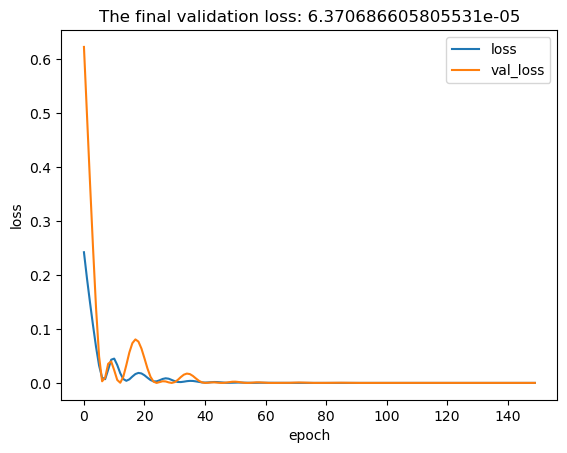

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_96311/3370771014.py:33: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  next_input = np.array([[last, next[0]]], dtype=np.float64)


MSE:  0.0038648663141063466


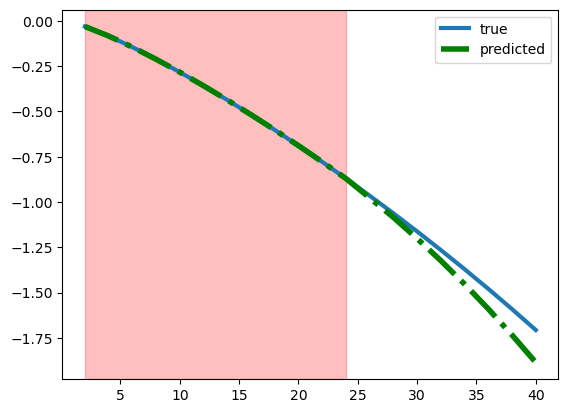

Time:  9.258906042000035
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 200)               40400     
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 1s 508ms/step - loss: 0.3482 - val_loss: 0.0510
Epoch 2/150
1/1 [==============================] - 0s 26ms/step - loss: 0.1302 - val_loss: 0.0027
Epoch 3/150
1/1 [==============================] - 0s 34ms/step - loss: 0.0223 - val_loss: 0.0883

1/1 [==============================] - 0s 34ms/step - loss: 7.2747e-04 - val_loss: 0.0118
Epoch 75/150
1/1 [==============================] - 0s 33ms/step - loss: 6.6635e-04 - val_loss: 0.0106
Epoch 76/150
1/1 [==============================] - 0s 34ms/step - loss: 6.2605e-04 - val_loss: 0.0094
Epoch 77/150
1/1 [==============================] - 0s 31ms/step - loss: 6.1860e-04 - val_loss: 0.0085
Epoch 78/150
1/1 [==============================] - 0s 35ms/step - loss: 6.3215e-04 - val_loss: 0.0080
Epoch 79/150
1/1 [==============================] - 0s 37ms/step - loss: 6.4300e-04 - val_loss: 0.0078
Epoch 80/150
1/1 [==============================] - 0s 32ms/step - loss: 6.3387e-04 - val_loss: 0.0080
Epoch 81/150
1/1 [==============================] - 0s 35ms/step - loss: 6.0485e-04 - val_loss: 0.0084
Epoch 82/150
1/1 [==============================] - 0s 34ms/step - loss: 5.7037e-04 - val_loss: 0.0089
Epoch 83/150
1/1 [==============================] - 0s 34ms/step - loss: 5.4662e-04 - 

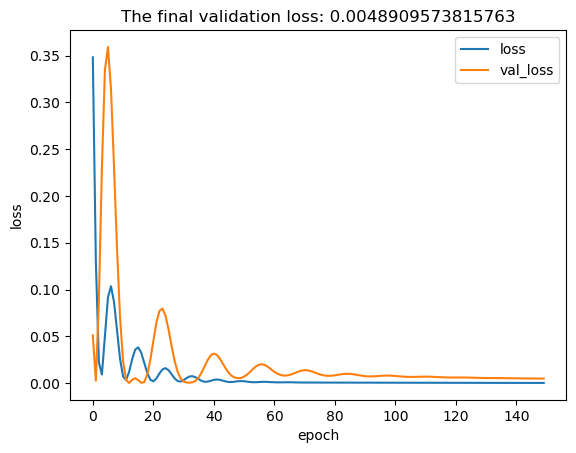

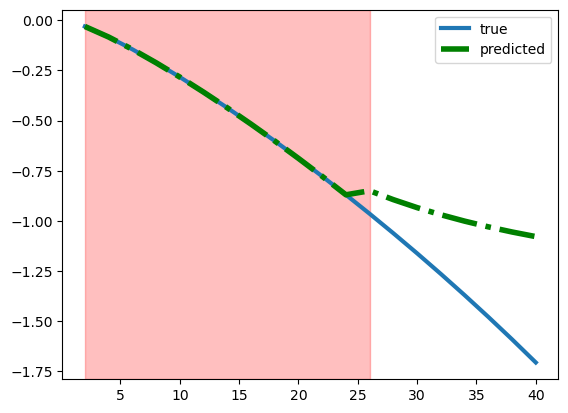

Time:  5.971330833000138


In [9]:
def lstm_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 250
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

def dnn2_gru2(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with four hidden layers (two dense followed by
        two GRU layers) and returns the model.
    """    
    # Number of neurons on the input/output layers and hidden layers
    in_out_neurons = 1
    hidden_neurons = 250
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden Dense (feedforward) layers
    dnn = Dense(hidden_neurons/2, activation='relu', name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    # Hidden GRU layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True)(dnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True)(rnn1)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the mdoel
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
model = dnn2_gru2(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)


# ### Training Recurrent Neural Networks in the Standard Way (i.e. learning the relationship between the X and Y data)
# 
# Finally, comparing the performace of a recurrent neural network using the standard data formatting to the performance of the network with time sequence data formatting shows the benefit of this type of data formatting with extrapolation.

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Reshape the data for Keras specifications
X_train = X_train.reshape((dim, 1))
y_train = y_train.reshape((dim, 1))


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Set the sequence length to 1 for regular data formatting 
model = rnn(length_of_sequences = 1)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_train, y_train, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict the remaining data points
X_pred = X_tot[dim:]
X_pred = X_pred.reshape((len(X_pred), 1))
y_model = model.predict(X_pred)
y_pred = np.concatenate((y_tot[:dim], y_model.flatten()))

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()

# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Autoencoders: Overarching view

Autoencoders are artificial neural networks capable of learning
efficient representations of the input data (these representations are called codings)  without
any supervision (i.e., the training set is unlabeled). These codings
typically have a much lower dimensionality than the input data, making
autoencoders useful for dimensionality reduction. 

More importantly, autoencoders act as powerful feature detectors, and
they can be used for unsupervised pretraining of deep neural networks.

Lastly, they are capable of randomly generating new data that looks
very similar to the training data; this is called a generative
model. For example, you could train an autoencoder on pictures of
faces, and it would then be able to generate new faces.  Surprisingly,
autoencoders work by simply learning to copy their inputs to their
outputs. This may sound like a trivial task, but we will see that
constraining the network in various ways can make it rather
difficult. For example, you can limit the size of the internal
representation, or you can add noise to the inputs and train the
network to recover the original inputs. These constraints prevent the
autoencoder from trivially copying the inputs directly to the outputs,
which forces it to learn efficient ways of representing the data. In
short, the codings are byproducts of the autoencoder’s attempt to
learn the identity function under some constraints.

## From supervised to unsupervised training

Neural networks are typically used in a supervised setting. Meaning
that for each training observation \(\mathbf{x}_{i}\)\textbf{ }we will
have one label or expected value \(\mathbf{y}_{i}\). During training,
the neural network model will learn the relationship between the input
data and the expected labels. Now suppose we have only unlabeled
observations, meaning we only have our training dataset $S_{T}$,made of the $M$ observations $\mathbf{x}_{i}$ with $i =1,\ldots ,M$

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
S_{T} =\left\{\mathbf{x}_{i} \vert  i = 1,\ldots ,M\right\}   \\ 
\label{_auto1} \tag{1}
\end{equation}
$$

Where in general $\mathbf{x}_{i}\in\mathbb{R}^{n}$ with $n\in\mathbb{N}$.

## First introduction of AEs

Autoencoders were first introduced by Rumelhart, Hinton, and Williams
in 1986 with the goal of learning to reconstruct the input
observations \(\mathbf{x}_{i}\) with the lowest error possible.

Why would one want to learn to reconstruct the input observations? If
you have problems imagining what that means, think of having a dataset
made of images. An autoencoder would be an algorithm that can give as
output an image that is as similar as possible to the input one. You
may be confused, as there is no apparent reason of doing so. To better
understand why autoencoders are useful we need a more informative
(although not yet unambiguous) definition.

An autoencoder is a type of algorithm with the primary purpose of learning an "informative" representation of the data that can be used for different applications ([see Bank, D., Koenigstein, N., and Giryes, R., Autoencoders](https://arxiv.org/abs/2003.05991)) by learning to reconstruct a set of input observations well enough.